###CORSID Comparison

##Load ground truth

In [25]:
import pandas as pd
import numpy as np
#import pysam
import matplotlib.pyplot as plt
from matplotlib import gridspec
import glob
import json
import seaborn as sns
from matplotlib_venn import venn2, venn3, venn3_unweighted, venn2_unweighted

In [26]:
%config InlineBackend.figure_formats = ['png']

In [27]:
df_gt_leader = pd.read_csv("/content/drive/MyDrive/ground_truth/gt_leader_range.csv").set_index("sample")

Specially, remove 2 samples with empty GTF annotation from comparison:

*   DQ288927
*   EU526388





In [28]:
df_gt_leader.loc["DQ288927", "pos"] = np.nan
df_gt_leader.loc["EU526388", "pos"] = np.nan

In [29]:
df_gt_leader_range = pd.read_csv("/content/drive/MyDrive/ground_truth/gt_leader_range.csv").set_index("sample")

In [30]:
with open("/content/drive/MyDrive/ground_truth/gt_regions.json") as ifile:
    gt_regions = json.load(ifile)

In [31]:
with open("/content/drive/MyDrive/ground_truth/gt_orf1ab.json") as ifile:
    gt_orf1ab = json.load(ifile)

Correct misclassified samples
SuPER misclassify sample NC_016996 as Moordecovirus, it should be Buldecovirus according to our analysis as well as annotation in GenBank: https://www.ncbi.nlm.nih.gov/nuccore/NC_016996 . More specifically, Moordecovirus is a canceled taxonomy which is merged into Buldecovirus in 2019 release.

https://journals.asm.org/doi/full/10.1128/JVI.06540-11

In [32]:
df_gt_leader.loc["NC_016996", "subgenus"] = "Buldecovirus"

In [33]:
def assign_orf(regions, start, end=None):
    for orf, pos in regions.items():
        if isinstance(pos, list):
            if end is None:
                if abs(pos[0] - start) <= 6:
                    return orf
            else:
                if abs(pos[0] - start) <= 3 and abs(pos[1] - end) <= 3:
                    return orf
        else:
            if end is None:
                if abs(pos - start) <= 6:
                    return orf
            else:
                if start - 6 <= pos <= end:
                    return orf
    return None

In [34]:
def get_corsid_df(pattern):
    files = glob.glob(pattern)
    summary = {}
    for file in files:
        sample = file.split("/")[-1].strip().split('.')[0]
        with open(file) as ifile:
            res = json.load(ifile)
            summary[sample] = res
    data = []
    cnt_1ab = 0
    for sample, s in summary.items():
        d = s["results"][0]
        orf1ab_start, _, _, orf1ab_end = s["ORF1ab"]
        orf1ab = gt_orf1ab[sample]
        if orf1ab is not None:
            has_1ab = (orf1ab_start - orf1ab[0] <= 3) and (orf1ab_end - orf1ab[1] <= 3)
        else:
            has_1ab = False
        orfs = [assign_orf(gt_regions[sample], x["ORF_start"], x["ORF_start"] + x["ORF_len"]) for x in d["bodys"]]
        TP = sum(o is not None for o in orfs)
        FP = sum(o is None for o in orfs)
        if has_1ab:
            cnt_1ab += 1
            TP = TP + 1 # TP
            FN = len(gt_regions[sample]) - TP + 1 # FN
            FP = FP # FP
        else:
            TP = TP # TP
            FN = len(gt_regions[sample]) + 1 - TP # FN
            FP = FP + 2 # FP
        data.append([sample, TP, FN, FP, d["weight"], d["leader_core_start"], 1-d["compact"], len(d["leader_core_seq"]), d["leader_core_seq"]])
    print(cnt_1ab)
    df = pd.DataFrame(data, columns=["sample", "TP", "FN", "FP", "max_weight", "leader", "compact", "length", "core_seq"])
    df["gt_leader"] = df_gt_leader.loc[df["sample"], "pos"].values
    df["gt_range_start"] = df_gt_leader_range.loc[df["sample"], "start"].values
    df["gt_range_end"] = df_gt_leader_range.loc[df["sample"], "end"].values
    df["genus"] = df_gt_leader.loc[df["sample"], "genus"].values
    df["subgenus"] = df_gt_leader.loc[df["sample"], "subgenus"].values
    df["dist"] = df["leader"] - df["gt_leader"]
    df["incomplete"] = df["gt_leader"].isna()
    df["correct"] = df["dist"].apply(lambda x: np.NaN if x!=x else abs(x) <= 6)
    df["correct_range"] = df.apply(lambda x: np.NaN if x["incomplete"] else x["gt_range_start"] <= x["leader"] <= x["gt_range_end"], axis=1)
    df["old_correct"] = df.set_index("sample").loc[df["sample"], "correct"].values
    df["precision"] = df["TP"] / (df["TP"] + df["FP"])
    df["recall"] = df["TP"] / (df["TP"] + df["FN"])
    df["F1"] = 2 / (1 / df["precision"] + 1 / df["recall"])
    return df

In [35]:
df_corsid = get_corsid_df("/content/drive/MyDrive/CORSID/*.json")

492


In [36]:
df_corsid_v2 = get_corsid_df("/content/drive/MyDrive/CORSID_v2/*.json")

490


*looks like there are 2 missing points in the CORSID_v2, will have to look further into this*

<ipython-input-39-4736f236af1b>:80: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(y="method", x="precision", data=df_combine, jitter=0.3, alpha=.1,
<ipython-input-39-4736f236af1b>:95: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x="method", y="recall", data=df_combine, jitter=0.3, alpha=.1, linewidth=0.5,


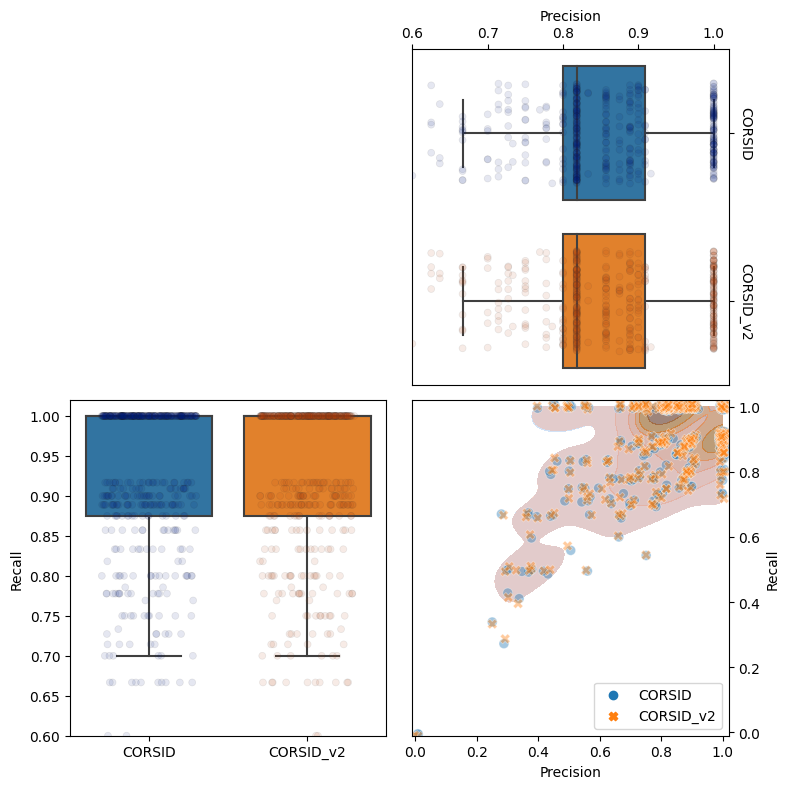

In [39]:
df = df_corsid

df_combine = pd.concat([pd.DataFrame({
    "sample": df.loc[(df["incomplete"]), "sample"],
    #"correct": df.loc[(~df["incomplete"]), "correct"],
    #"correct_range": df.loc[(~df["incomplete"]), "correct_range"],
    "recall": df.loc[(df["incomplete"]), "recall"],
    "precision": df.loc[(df["incomplete"]), "precision"],
    "F1": df.loc[(df["incomplete"]), "F1"],
    "genus": df.loc[(df["incomplete"]), "genus"],
    "method": "CORSID",
})], ignore_index=True)

df = df_corsid_v2
df_combine = pd.concat([df_combine, pd.DataFrame({
    "sample": df.loc[(df["incomplete"]), "sample"],
    "correct": df.loc[(df["incomplete"]), "correct"],
    "correct_range": df.loc[(df["incomplete"]), "correct_range"],
    "recall": df.loc[(df["incomplete"]), "recall"],
    "precision": df.loc[(df["incomplete"]), "precision"],
    "F1": df.loc[(df["incomplete"]), "F1"],
    "genus": df.loc[(df["incomplete"]), "genus"],
    "method": "CORSID_v2",
})], ignore_index=True)

#print(df_combine.head())


fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(6, 6)

axes = []
ax = fig.add_subplot(gs[3:, 3:])
axes.append(ax)
sns.kdeplot(
    data=df_combine,
    x="precision",
    y="recall",
    hue="method",
    fill=True,
    levels=7,
    alpha=0.5,
    cut=0,
    legend=False,
    ax=ax,
)
df_combine_jitter = df_combine.copy()
np.random.seed(0)
df_combine_jitter['recall'] = df_combine_jitter['recall'] + 0.005*np.random.randn(len(df_combine_jitter))
df_combine_jitter['precision'] = df_combine_jitter['precision'] + 0.005*np.random.randn(len(df_combine_jitter))
sns.scatterplot(
    data=df_combine_jitter,
    x="precision",
    y="recall",
    hue="method",
    style="method",
    alpha=0.4,
    s=50,
    ax=ax,
)
ax.set_xlim((-.01,1.02))
ax.set_ylim((-.01,1.02))
ax.set_ylabel("Recall")
ax.set_xlabel('Precision')
# ax.set_xticks([])
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position("top")
ax.legend(title=None, loc="lower right")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
# ax.set_aspect('equal', adjustable='box')

#print(df_combine.head())


ax = fig.add_subplot(gs[:3, 3:])
axes.append(ax)

sns.boxplot(y="method", x="precision", data=df_combine, showfliers=False, orient="h", ax=ax)
sns.stripplot(y="method", x="precision", data=df_combine, jitter=0.3, alpha=.1,
              linewidth=0.5, edgecolor="gray", ax=ax, palette='dark')
ax.set_xlabel("Precision")
ax.set_xlim((0.6,1.02))
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.yaxis.tick_right()
ax.set_yticklabels([t._text for t in ax.yaxis.get_ticklabels()], rotation=-90, va="center")
ax.set_ylabel(None)
ax.yaxis.set_label_position("right")


ax = fig.add_subplot(gs[3:, :3])
axes.append(ax)
sns.boxplot(x="method", y="recall", data=df_combine, showfliers=False, ax=ax)
sns.stripplot(x="method", y="recall", data=df_combine, jitter=0.3, alpha=.1, linewidth=0.5,
              edgecolor="gray", ax=ax, palette='dark')
# ax.set_xticks([])
ax.set_ylabel("Recall")
ax.set_ylim((0.6,1.02))
ax.set_xlabel(None)


for ax in axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
plt.tight_layout()

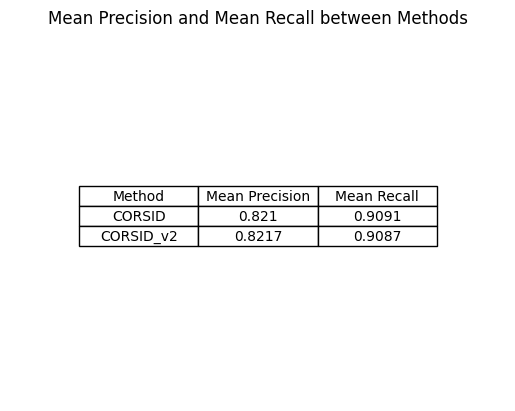

In [40]:
mean_precision = df_combine.groupby('method')['precision'].mean().round(4)
mean_recall = df_combine.groupby('method')['recall'].mean().round(4)

metrics_df = pd.DataFrame({
    'Method': mean_precision.index,
    'Mean Precision': mean_precision.values,
    'Mean Recall': mean_recall.values
})


fig, ax = plt.subplots()
table_data = [metrics_df.columns] + metrics_df.values.tolist()
table = ax.table(cellText=table_data, loc='center', colWidths=[0.2] * len(metrics_df.columns), cellLoc='center')

# Customize the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust the table size

# Remove axis
ax.axis('off')

# Show the plot
plt.title('Mean Precision and Mean Recall between Methods')
plt.show()